In [17]:
 # These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm

In [16]:
!git pull

remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 6 (delta 3), reused 6 (delta 3), pack-reused 0
Unpacking objects: 100% (6/6), done.
From https://github.com/cgre-aachen/gempy
   67ecaa6..261b7f8  hmc_dev    -> origin/hmc_dev
Updating 67ecaa6..261b7f8
Fast-forward
 gempy/bayesian/joyplot.py        | 532 +++++++++++++++++++++++++++++++++++++++
 gempy/bayesian/plot_posterior.py |   4 +-
 2 files changed, 534 insertions(+), 2 deletions(-)
 create mode 100644 gempy/bayesian/joyplot.py


In [18]:
path_to_data = os.pardir+"/../data/input_data/jan_models/"

geo_data = gp.create_data([0,1000,0,1000,0,1000],resolution=[50,50,50], 
                        path_o = path_to_data + "model1_orientations.csv",
                        path_i = path_to_data + "model1_surface_points.csv") 

Active grids: ['regular']


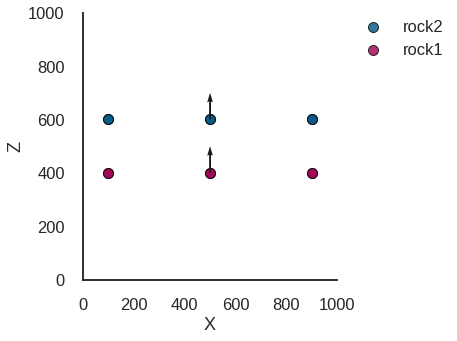

In [19]:
gp.plot.plot_data(geo_data)

We are going to make a likelihood function depending on the thickness of rock1 and 2. The most computing friendly way to do so is by adding the thickness as an attribute of the surfaces:

In [20]:
# This is the thickness of voxel
dz = geo_data.grid.regular_grid.dz
dz

20.0

In [21]:
geo_data.surfaces.add_surfaces_values([0, dz, 0], ['dz'])

,surface,series,order_surfaces,isBasement,color,id,dz
0,rock2,Default series,1,False,#015482,1,0
1,rock1,Default series,2,False,#9f0052,2,20
2,basement,Basement,1,True,#ffbe00,3,0


Now we can set the interpolator without compile theano. This will only create the graph:

In [22]:
gp.set_interpolation_data(geo_data, theano_optimizer='fast_run',
                          compile_theano=False, gradient=True)

## Compiling gempy with PyMC3

Next we need to compute a theano Op from the gempy graph:

In [23]:
import theano
import theano.tensor as T
theano.config.compute_test_value = 'ignore'

In [24]:
geo_model_T = theano.OpFromGraph(geo_data.interpolator.theano_graph.input_parameters_loop,
                               [geo_data.interpolator.theano_graph.compute_series()[0][1][0:125000]], inline=True,
                                 on_unused_input='ignore',
                                 name='geo_model')

In [25]:
import theano
import theano.tensor as tt
theano.config.compute_test_value = 'ignore'
# We convert a python variable to theano.shared
input_sh = []
i = geo_data.interpolator.get_python_input_block()
for ii in i:
    input_sh.append(theano.shared(ii))

# We get the rescaling parameters:
rf = geo_data.rescaling.df.loc['values', 'rescaling factor']
centers = geo_data.rescaling.df.loc['values', 'centers']

# We create pandas groups by id to be able to modify several points at the same time:
g = geo_data.surface_points.df.groupby('id')
l = theano.shared(np.array([], dtype='float32'))

In [26]:
# PyMC3 model
theano.config.compute_test_value = 'ignore'

with pm.Model() as model:
    r2 = pm.Normal('rock2', 600, 50)
    r1 = pm.Normal('rock1', 400, 50)

    val2 = (r2 - centers[2]) / rf + 0.5001
    val1 = (r1 - centers[2]) / rf + 0.5001
    

    input_sh[4] = tt.set_subtensor(input_sh[4][g.groups[1], 2], val2)
    input_sh[4] = tt.set_subtensor(input_sh[4][g.groups[2], 2], val1)
    
    # we have to take the sol 0
    geo = geo_model_T(*input_sh)
    well = geo.reshape((50, 50, 50))[25,25,:]
   
    thickness = pm.Deterministic('thickness', well.sum())
    likelihood_function = pm.Normal('y', mu=thickness, sd=20, observed=120)

In [27]:
with model:
    t = pm.load_trace('thickness_NUTS')
    t_metro = pm.load_trace('thickness_Metro')

In [28]:
import gempy.bayesian.plot_posterior as pp
t_df =pm.trace_to_dataframe(t_metro)


In [29]:
import importlib
importlib.reload(pp)

<module 'gempy.bayesian.plot_posterior' from '../../../gempy/bayesian/plot_posterior.py'>

In [30]:
joypy.joyplot?

Object `joypy.joyplot` not found.


In [31]:
t_nuts_df =pm.trace_to_dataframe(t)


{'subplot': 121, 'sample_size': 10000, 'theta1_name': 'rock1', 'theta2_name': 'rock2', 'n_traces': 101, 'yrot': 70}
True


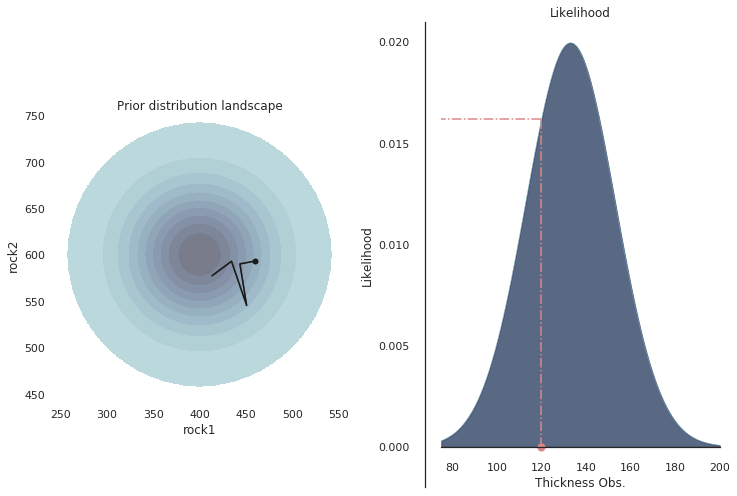

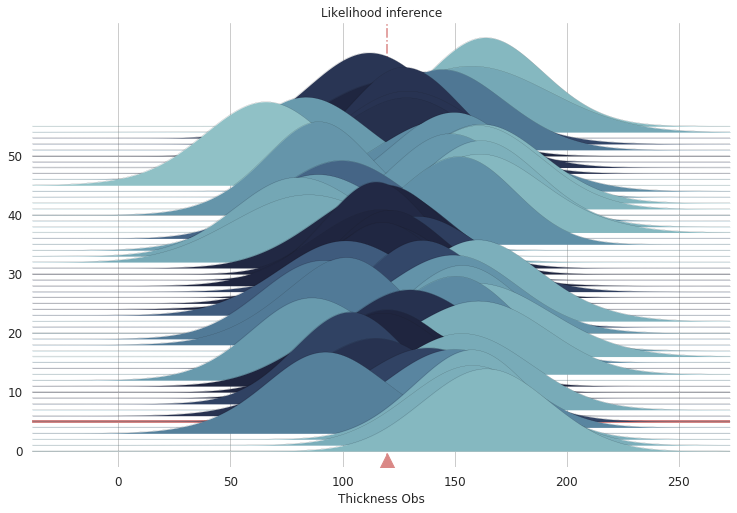

<Figure size 748.8x514.8 with 0 Axes>

In [32]:
importlib.reload(pp)
pp.plot_posterior(t_nuts_df, theta1_loc=600, theta1_scale=50,
                  theta2_loc=400, theta2_scale=50,
                  iteration=5,
                  model_mean_name='thickness', model_std=20.,
                  obs=120,
                  x_range=(75,200), sample_size=10000,
                  theta1_name='rock1', theta2_name='rock2', n_traces=101, yrot=70
              )


In [33]:
def post_interact(iteration):
    pp.plot_posterior(t_nuts_df, theta1_loc=600, theta1_scale=50,
                  theta2_loc=400, theta2_scale=50,
                  iteration=iteration,
                  model_mean_name='thickness', model_std=20.,
               obs=120,
               x_range=(75,200), sample_size=100, n_traces=11,
                                        theta1_name='rock1', theta2_name='rock2'

              )


In [34]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(post_interact, iteration=(0, 1000, 1))

interactive(children=(IntSlider(value=500, description='iteration', max=1000), Output()), _dom_classes=('widge…

<function __main__.post_interact(iteration)>